In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path # Use pathlib for easier path handling
import time
import random

# --- Configuration ---
# !! IMPORTANT: Adjust this path if your notebook isn't running on the DTU server
# !! or if the data is located elsewhere.
DATA_DIR = Path("/dtu/projects/02613_2025/data/modified_swiss_dwellings/")

# Number of floorplans to visualize
NUM_TO_VISUALIZE = 3

In [7]:
# Find all '_domain.npy' files and extract the building IDs
try:
    domain_files = list(DATA_DIR.glob('*_domain.npy'))
    if not domain_files:
        print(f"ERROR: No '_domain.npy' files found in {DATA_DIR}")
        building_ids = []
    else:
        # Extract the ID part (e.g., '10000' from '10000_domain.npy')
        building_ids = sorted([f.name.replace('_domain.npy', '') for f in domain_files])
        print(f"Found {len(building_ids)} building IDs.")
        # Select a few random IDs to visualize
        if len(building_ids) >= NUM_TO_VISUALIZE:
            ids_to_visualize = random.sample(building_ids, NUM_TO_VISUALIZE)
        else:
            ids_to_visualize = building_ids # Visualize all if fewer than requested
        print(f"Selected IDs for visualization: {ids_to_visualize}")

except Exception as e:
    print(f"An error occurred while listing files: {e}")
    ids_to_visualize = [] # Ensure this list exists even if there's an error

Found 4571 building IDs.
Selected IDs for visualization: ['13594', '3363', '24511']


In [4]:
def load_floorplan_data(building_id, data_dir):
    """
    Loads the domain and interior data for a given building ID.

    Args:
        building_id (str): The numerical ID of the building.
        data_dir (Path): The directory containing the data files.

    Returns:
        tuple: (domain_array, interior_array) or (None, None) if files are missing.
    """
    domain_path = data_dir / f"{building_id}_domain.npy"
    interior_path = data_dir / f"{building_id}_interior.npy"

    if not domain_path.exists():
        print(f"Warning: Domain file not found for ID {building_id} at {domain_path}")
        return None, None
    if not interior_path.exists():
        print(f"Warning: Interior file not found for ID {building_id} at {interior_path}")
        return None, None

    try:
        domain_data = np.load(domain_path)
        interior_mask = np.load(interior_path)
        print(f"Successfully loaded data for ID {building_id}")
        print(f"  Domain shape: {domain_data.shape}, Unique values: {np.unique(domain_data)}")
        print(f"  Interior shape: {interior_mask.shape}, Unique values: {np.unique(interior_mask)}")
        # Basic validation
        if domain_data.shape != (514, 514) or interior_mask.shape != (514, 514):
             print(f"Warning: Unexpected array shape for ID {building_id}")

        return domain_data, interior_mask
    except Exception as e:
        print(f"Error loading files for ID {building_id}: {e}")
        return None, None

In [5]:
def plot_floorplan(building_id, domain_data, interior_mask):
    """
    Plots the domain and interior mask side-by-side.
    """
    if domain_data is None or interior_mask is None:
        print(f"Skipping plot for ID {building_id} due to missing data.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Adjust figsize as needed

    # --- Plot Domain Data ---
    # Use specific values for ticks if desired, or just let colorbar handle it
    cmap_domain = plt.cm.viridis # Choose a colormap
    norm_domain = plt.Normalize(vmin=0, vmax=25) # Set normalization range based on expected values
    im_domain = axes[0].imshow(domain_data, cmap=cmap_domain, norm=norm_domain)
    axes[0].set_title(f"Domain (Initial Conditions)\n0:Air, 5:Load Wall, 25:Inner Wall")
    axes[0].axis('off') # Hide axes ticks and labels
    # Add colorbar for domain
    cbar_domain = fig.colorbar(im_domain, ax=axes[0], ticks=[0, 5, 25], fraction=0.046, pad=0.04)
    cbar_domain.set_label("Grid Value")


    # --- Plot Interior Mask ---
    cmap_interior = plt.cm.gray # Grayscale is good for binary masks
    norm_interior = plt.Normalize(vmin=0, vmax=1)
    im_interior = axes[1].imshow(interior_mask, cmap=cmap_interior, norm=norm_interior)
    axes[1].set_title(f"Interior Mask\n(1 = Interior Point)")
    axes[1].axis('off') # Hide axes ticks and labels
    # Add colorbar for interior mask
    cbar_interior = fig.colorbar(im_interior, ax=axes[1], ticks=[0, 1], fraction=0.046, pad=0.04)
    cbar_interior.set_label("Mask Value")


    # --- Overall Figure ---
    fig.suptitle(f"Floorplan Visualization: ID {building_id}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


--- Visualizing 3 Floorplans ---

Processing ID: 8232
Successfully loaded data for ID 8232
  Domain shape: (512, 512), Unique values: [ 0.  5. 25.]
  Interior shape: (512, 512), Unique values: [False  True]


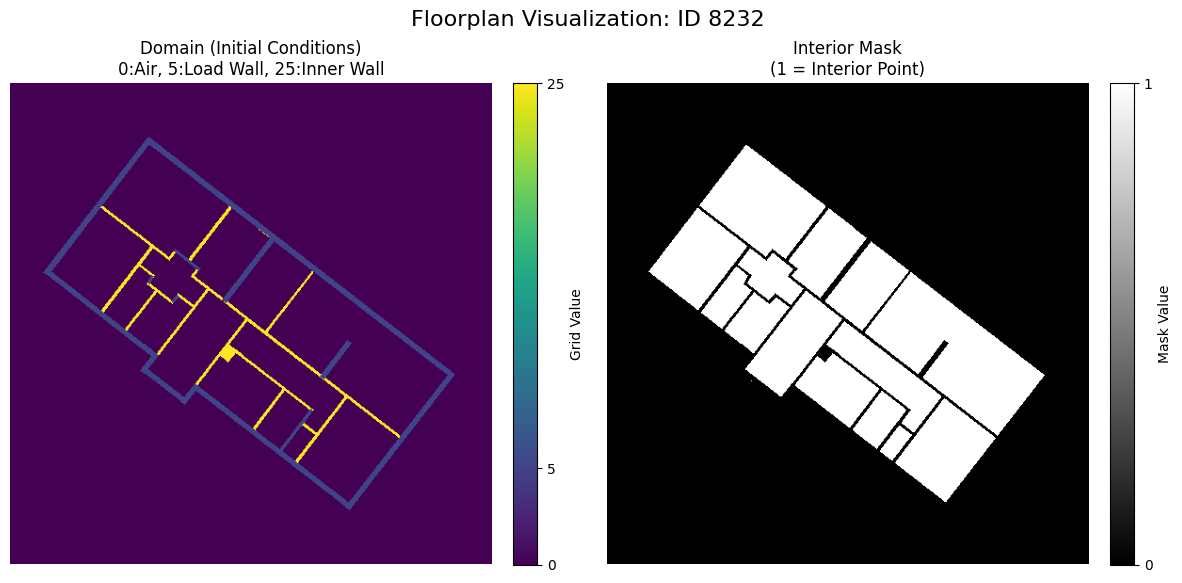


Processing ID: 3911
Successfully loaded data for ID 3911
  Domain shape: (512, 512), Unique values: [ 0.  5. 25.]
  Interior shape: (512, 512), Unique values: [False  True]


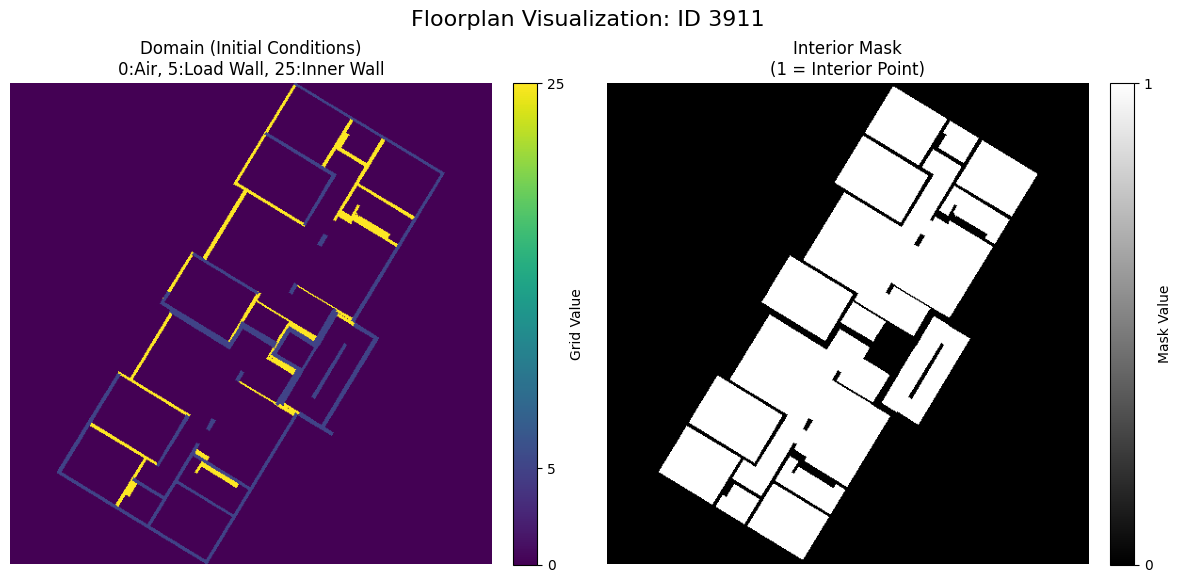


Processing ID: 10182
Successfully loaded data for ID 10182
  Domain shape: (512, 512), Unique values: [ 0.  5. 25.]
  Interior shape: (512, 512), Unique values: [False  True]


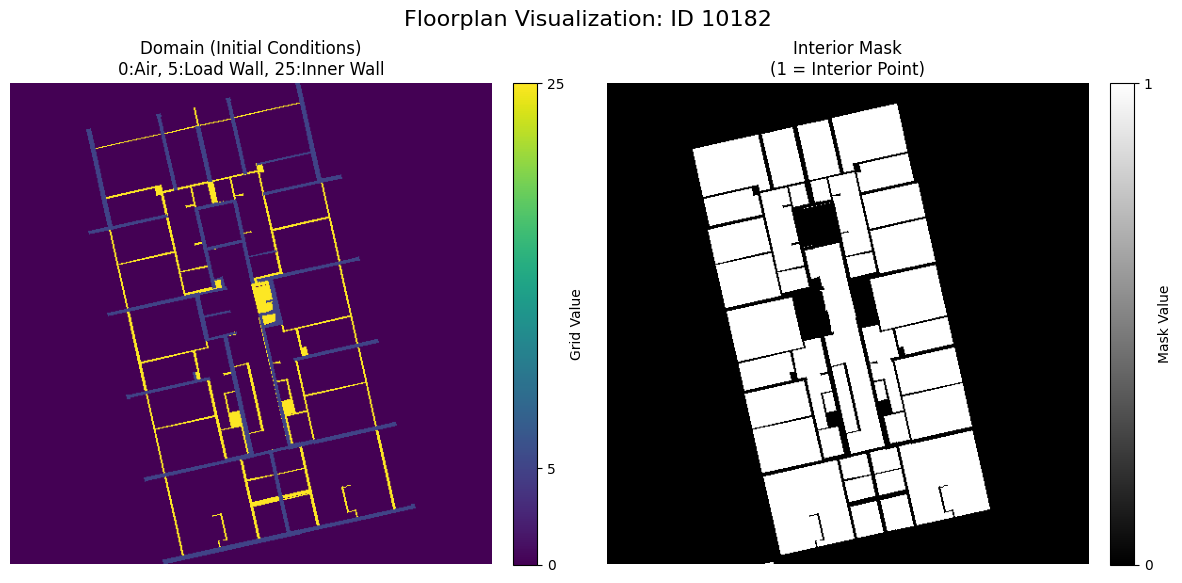


--- Visualization Complete ---


In [6]:
# Iterate through the selected IDs, load data, and plot
if not ids_to_visualize:
    print("\nNo floorplan IDs selected or found. Cannot visualize.")
else:
    print(f"\n--- Visualizing {len(ids_to_visualize)} Floorplans ---")
    for bid in ids_to_visualize:
        print(f"\nProcessing ID: {bid}")
        domain, interior = load_floorplan_data(bid, DATA_DIR)
        plot_floorplan(bid, domain, interior)
    print("\n--- Visualization Complete ---")

In [10]:
LOAD_DIR = Path("/dtu/projects/02613_2025/data/modified_swiss_dwellings/")
BUILDING_IDS_FILE = LOAD_DIR / 'building_ids.txt'

# Simulation Parameters
MAX_ITER = 20_000 # Max iterations for Jacobi
ABS_TOL = 1e-4    # Absolute tolerance for convergence

# Subset Configuration for Timing
NUM_SUBSET = 15 # Number of floorplans to process for timing (e.g., 10-20)

# Visualization Configuration
NUM_TO_VISUALIZE = 3 # How many results to plot

In [14]:
# Note: Using Path.joinpath instead of os.path.join
# Note: The original script loads the domain into the *center* of a pre-padded array.

def load_data(load_dir, bid):
    """Loads domain and interior mask for a building ID."""
    SIZE = 512 # Base size, the script implicitly uses 514x514 arrays with padding
    u = np.zeros((SIZE + 2, SIZE + 2)) # Creates a 514x514 array

    domain_path = load_dir / f"{bid}_domain.npy"
    interior_path = load_dir / f"{bid}_interior.npy"

    if not domain_path.exists() or not interior_path.exists():
         print(f"Warning: Data files missing for ID {bid}. Skipping.")
         return None, None

    try:
        # Load the full 514x514 domain file directly
        u_loaded = np.load(domain_path)
        if u_loaded.shape == (514, 514):
            u = u_loaded # Use the loaded array directly if it's the correct padded size
        elif u_loaded.shape == (512, 512):
             u[1:-1, 1:-1] = u_loaded # Place it in the center if it's 512x512
        else:
            print(f"Warning: Unexpected domain shape {u_loaded.shape} for ID {bid}. Skipping.")
            return None, None

        # Interior mask is expected to be 512x512
        interior_mask_loaded = np.load(interior_path)
        if interior_mask_loaded.shape != (512, 512):
             print(f"Warning: Unexpected interior mask shape {interior_mask_loaded.shape} for ID {bid}. Skipping.")
             return None, None
        interior_mask = interior_mask_loaded.astype(bool) # Ensure boolean type

        return u, interior_mask
    except Exception as e:
        print(f"Error loading data for ID {bid}: {e}")
        return None, None


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    """Performs Jacobi iteration."""
    # Ensure 'u' is float for calculations
    u = np.copy(u).astype(float)
    u_new = np.copy(u) # Create a buffer for the new values

    delta = np.inf # Initialize delta to a large value
    iter_count = 0

    for i in range(max_iter):
        iter_count = i + 1
        # Compute average of neighbors using slicing on the padded 'u'
        # Neighbors for the inner grid u[1:-1, 1:-1]
        neighbors_sum = (u[1:-1, :-2] +  # Left
                         u[1:-1, 2:] +   # Right
                         u[:-2, 1:-1] +  # Up
                         u[2:, 1:-1])    # Down

        # Update only the interior points defined by the mask
        # Important: u_new[1:-1, 1:-1] and neighbors_sum have shape (512, 512)
        # interior_mask also has shape (512, 512)
        u_new[1:-1, 1:-1][interior_mask] = 0.25 * neighbors_sum[interior_mask]

        # Calculate maximum absolute difference *only* on interior points
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new[1:-1, 1:-1][interior_mask]).max()

        # Update the original array for the next iteration
        # Crucial: Update only the interior points to preserve boundary/wall conditions
        u[1:-1, 1:-1][interior_mask] = u_new[1:-1, 1:-1][interior_mask]

        if delta < atol:
            # print(f"Converged after {iter_count} iterations with delta={delta:.2e}")
            break
    # else: # Optional: Indicate if max_iter was reached
        # print(f"Reached max_iter={max_iter} with delta={delta:.2e}")

    return u, iter_count, delta # Return final state, iterations taken, final delta


def summary_stats(u, interior_mask):
    """Calculates summary statistics for interior points."""
    # Select the 512x512 inner part corresponding to the mask
    u_inner = u[1:-1, 1:-1]
    # Select only the points *inside* rooms using the boolean mask
    u_interior = u_inner[interior_mask]

    if u_interior.size == 0: # Handle cases with no interior points if they exist
        return {
            'mean_temp': np.nan, 'std_temp': np.nan,
            'pct_above_18': np.nan, 'pct_below_15': np.nan,
            'min_temp': np.nan, 'max_temp': np.nan
        }

    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    min_temp = u_interior.min()
    max_temp = u_interior.max()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp, 'std_temp': std_temp,
        'pct_above_18': pct_above_18, 'pct_below_15': pct_below_15,
        'min_temp': min_temp, 'max_temp': max_temp
    }

In [15]:
# Load all available building IDs
try:
    with open(BUILDING_IDS_FILE, 'r') as f:
        all_building_ids = sorted(f.read().splitlines()) # Sort for consistency
    print(f"Loaded {len(all_building_ids)} building IDs.")

    if not all_building_ids:
        print("ERROR: Building IDs file is empty.")
        subset_building_ids = []
    elif len(all_building_ids) < NUM_SUBSET:
        print(f"Warning: Requested subset size ({NUM_SUBSET}) is larger than total IDs ({len(all_building_ids)}). Using all IDs.")
        subset_building_ids = all_building_ids
        NUM_SUBSET = len(all_building_ids) # Adjust subset number
    else:
        # Select a random subset for timing, or the first N for simplicity
        # subset_building_ids = random.sample(all_building_ids, NUM_SUBSET) # Random sample
        subset_building_ids = all_building_ids[:NUM_SUBSET] # First N
        print(f"Selected the first {NUM_SUBSET} building IDs for processing: {subset_building_ids}")

except Exception as e:
    print(f"Error reading building IDs file: {e}")
    all_building_ids = []
    subset_building_ids = []

Loaded 4571 building IDs.
Selected the first 15 building IDs for processing: ['10000', '10009', '10014', '10019', '10029', '10031', '10051', '10053', '10056', '10064', '10075', '10079', '10080', '10082', '10083']


In [16]:
# Load initial data for the selected subset
subset_u0 = {}
subset_interior_mask = {}
subset_stats = {} # To store results
valid_ids_processed = [] # Keep track of IDs successfully processed

print(f"\n--- Loading data for {len(subset_building_ids)} floorplans ---")
for bid in subset_building_ids:
    u0, interior_mask = load_data(LOAD_DIR, bid)
    if u0 is not None and interior_mask is not None:
        subset_u0[bid] = u0
        subset_interior_mask[bid] = interior_mask
        valid_ids_processed.append(bid)
    else:
        print(f"Skipping ID {bid} due to loading errors.")

print(f"\nSuccessfully loaded initial data for {len(valid_ids_processed)} floorplans.")
# Update NUM_SUBSET if some IDs failed loading
NUM_SUBSET = len(valid_ids_processed)


--- Loading data for 15 floorplans ---

Successfully loaded initial data for 15 floorplans.


In [17]:
subset_u_final = {} # Dictionary to store final state arrays
iteration_counts = {} # Store iteration counts
final_deltas = {} # Store final delta values

print(f"\n--- Running Jacobi Simulation for {NUM_SUBSET} floorplans ---")
print(f"Parameters: MAX_ITER={MAX_ITER}, ABS_TOL={ABS_TOL}")

start_time = time.perf_counter() # Start timer

for bid in valid_ids_processed:
    u0 = subset_u0[bid]
    interior_mask = subset_interior_mask[bid]

    # print(f"Processing ID: {bid}...") # Uncomment for verbose output
    u_final, iters, delta = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)

    subset_u_final[bid] = u_final
    iteration_counts[bid] = iters
    final_deltas[bid] = delta
    # Calculate stats immediately after simulation
    subset_stats[bid] = summary_stats(u_final, interior_mask)


end_time = time.perf_counter() # Stop timer
subset_duration = end_time - start_time

print(f"\n--- Simulation Complete ---")
print(f"Processed {NUM_SUBSET} floorplans in {subset_duration:.2f} seconds.")


--- Running Jacobi Simulation for 15 floorplans ---
Parameters: MAX_ITER=20000, ABS_TOL=0.0001

--- Simulation Complete ---
Processed 15 floorplans in 114.27 seconds.


In [18]:
if NUM_SUBSET > 0 and all_building_ids:
    avg_time_per_floorplan = subset_duration / NUM_SUBSET
    total_floorplans = len(all_building_ids)
    estimated_total_time_sec = avg_time_per_floorplan * total_floorplans
    estimated_total_time_min = estimated_total_time_sec / 60
    estimated_total_time_hr = estimated_total_time_min / 60

    print(f"\n--- Runtime Estimation ---")
    print(f"Average time per floorplan (based on subset): {avg_time_per_floorplan:.3f} seconds")
    print(f"Total number of floorplans: {total_floorplans}")
    print(f"Estimated total time for all floorplans:")
    print(f"  - Seconds: {estimated_total_time_sec:.2f}")
    print(f"  - Minutes: {estimated_total_time_min:.2f}")
    print(f"  - Hours:   {estimated_total_time_hr:.2f}")
    print("\nNote: This is an estimate. Actual time may vary based on system load and convergence differences.")
else:
    print("\n--- Runtime Estimation ---")
    print("Cannot estimate runtime (no floorplans processed or total count unavailable).")


--- Runtime Estimation ---
Average time per floorplan (based on subset): 7.618 seconds
Total number of floorplans: 4571
Estimated total time for all floorplans:
  - Seconds: 34821.50
  - Minutes: 580.36
  - Hours:   9.67

Note: This is an estimate. Actual time may vary based on system load and convergence differences.


In [21]:
print(f"\n--- Summary Statistics for Processed Subset ({NUM_SUBSET} floorplans) ---")

if not subset_stats:
    print("No statistics calculated.")
else:
    # Prepare header - get keys from the first valid stat entry
    first_key = next(iter(subset_stats))
    stat_keys = list(subset_stats[first_key].keys())

    # Print Header
    header = "building_id, iterations, final_delta, " + ", ".join(stat_keys)
    print(header)
    print("-" * len(header))

    # Print Data Rows
    for bid in valid_ids_processed:
        stats = subset_stats[bid]
        iters = iteration_counts[bid]
        delta = final_deltas[bid]
        stats_str = ", ".join(f"{stats[k]:.4f}" if isinstance(stats[k], (float, np.float64)) else str(stats[k]) for k in stat_keys)
        print(f"{bid}, {iters}, {delta:.2e}, {stats_str}")


--- Summary Statistics for Processed Subset (15 floorplans) ---
building_id, iterations, final_delta, mean_temp, std_temp, pct_above_18, pct_below_15, min_temp, max_temp
---------------------------------------------------------------------------------------------------------
10000, 3602, 1.00e-04, 14.0123, 6.3674, 30.9410, 55.5423, 0.9084, 24.9991
10009, 5493, 9.99e-05, 11.0001, 5.8111, 16.6713, 74.9724, 5.0000, 25.0000
10014, 7965, 9.99e-05, 14.7442, 7.0377, 38.2637, 52.8084, 0.6781, 25.0000
10019, 7870, 9.99e-05, 14.7355, 7.0303, 38.1492, 52.9293, 0.6405, 25.0000
10029, 3493, 9.98e-05, 10.6160, 6.3173, 18.2556, 74.5130, 2.5000, 25.0000
10031, 4735, 9.99e-05, 12.5071, 6.2784, 24.0447, 66.3951, 5.0002, 24.9977
10051, 1535, 9.97e-05, 13.2890, 5.9991, 25.9769, 62.8599, 0.7763, 24.9869
10053, 4479, 9.99e-05, 11.3665, 6.2612, 19.9511, 72.4105, 0.7462, 24.9952
10056, 1592, 9.97e-05, 14.2201, 6.1795, 31.7635, 57.0617, 2.5000, 25.0000
10064, 6518, 9.99e-05, 12.7170, 6.9642, 28.7914, 62.7569,

In [22]:
def plot_simulation_results(building_id, u0, u_final, interior_mask):
    """Plots initial conditions, final state, and interior mask."""

    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Adjust figsize as needed

    # --- Plot Initial State (Domain) ---
    cmap_temp = plt.cm.coolwarm # Colormap for temperature
    # Determine sensible bounds for temperature visualization
    # Use stats if available, otherwise guess or use fixed range
    stats = subset_stats.get(building_id, {})
    vmin = stats.get('min_temp', 0) # Use actual min if calculated
    vmax = stats.get('max_temp', 25) # Use actual max if calculated, or maybe a bit more than wall temp
    if np.isnan(vmin): vmin=0
    if np.isnan(vmax): vmax=30 # Fallback if stats failed

    im0 = axes[0].imshow(u0, cmap=cmap_temp, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Initial State (u0)\nID: {building_id}")
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], label="Value/Temperature", fraction=0.046, pad=0.04)

    # --- Plot Final State (u_final) ---
    im_final = axes[1].imshow(u_final, cmap=cmap_temp, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Final State (u_final)\nIterations: {iteration_counts.get(building_id, 'N/A')}")
    axes[1].axis('off')
    fig.colorbar(im_final, ax=axes[1], label="Temperature", fraction=0.046, pad=0.04)

    # --- Plot Interior Mask ---
    # Create a combined view: overlay mask on final state or show separately
    # Option 1: Show mask separately
    cmap_mask = plt.cm.gray
    im_mask = axes[2].imshow(interior_mask, cmap=cmap_mask, vmin=0, vmax=1)
    axes[2].set_title(f"Interior Mask (512x512)\n(1 = Interior Point)")
    axes[2].axis('off')
    # Option 2: Overlay mask (more complex, might obscure data)
    # final_masked = np.where(interior_mask, u_final[1:-1, 1:-1], np.nan) # Show only interior temps
    # axes[2].imshow(final_masked, cmap=cmap_temp, vmin=vmin, vmax=vmax)
    # axes[2].set_title(f"Final Interior Temp")
    # axes[2].axis('off')


    # --- Overall Figure ---
    # fig.suptitle(f"Simulation Results: ID {building_id}", fontsize=16) # Title already on subplots
    plt.tight_layout()#rect=[0, 0.03, 1, 0.95])
    plt.show()


--- Visualizing Results for 3 Floorplans ---

Visualizing ID: 10000


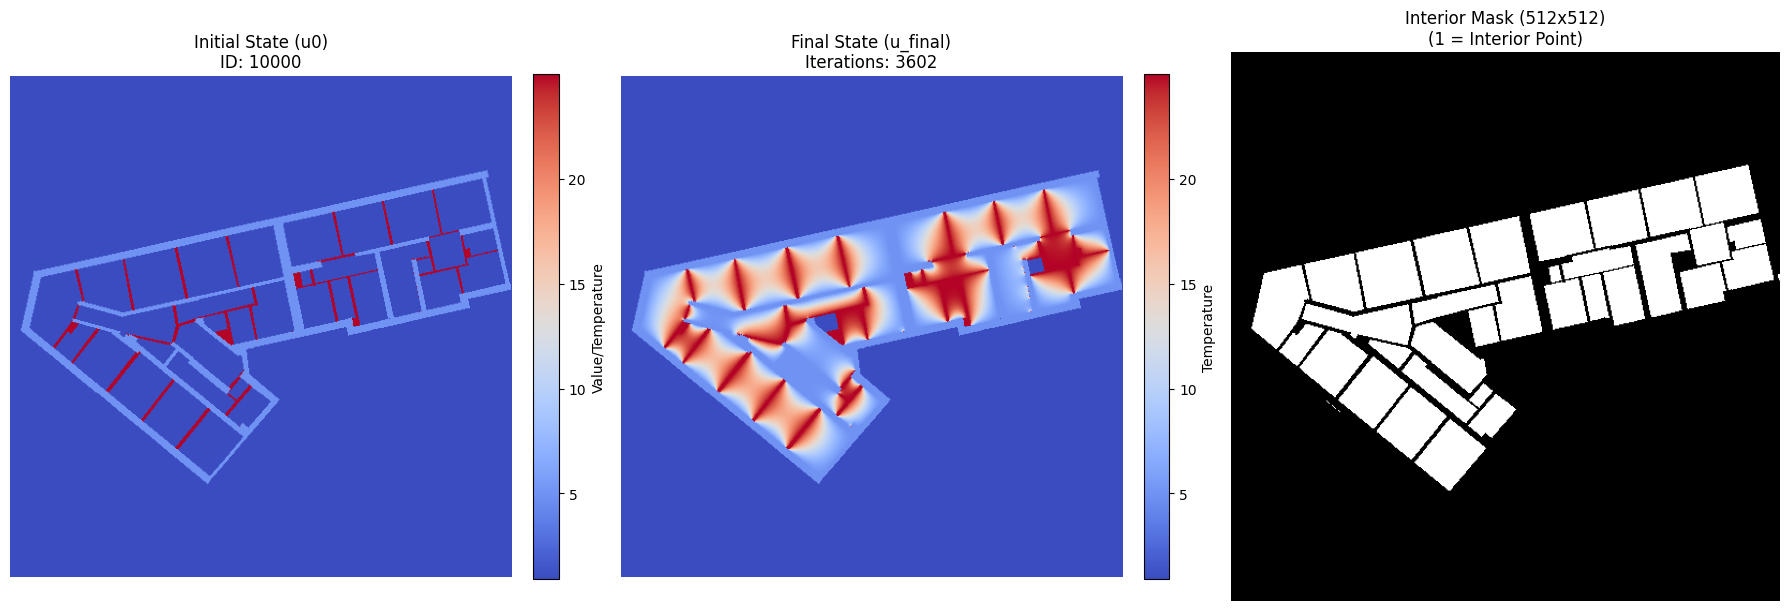


Visualizing ID: 10009


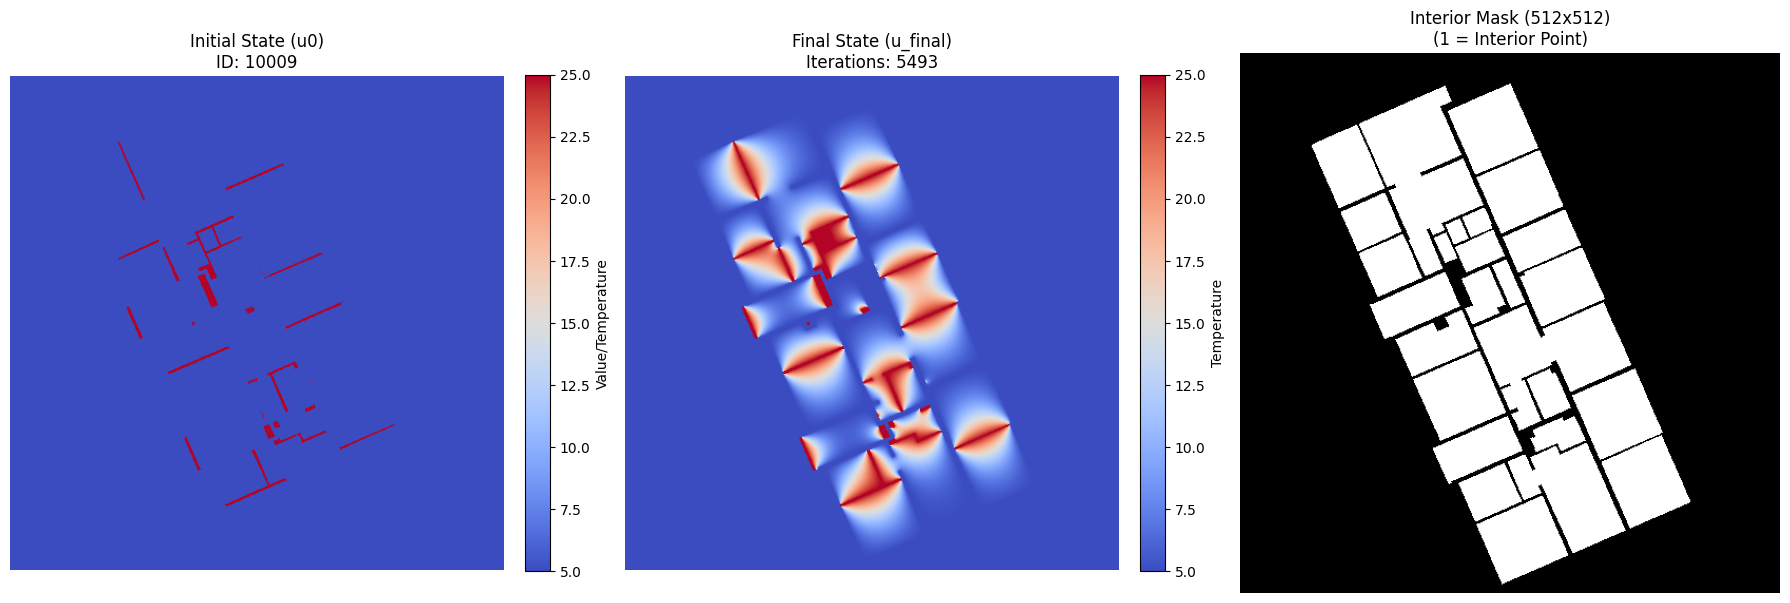


Visualizing ID: 10014


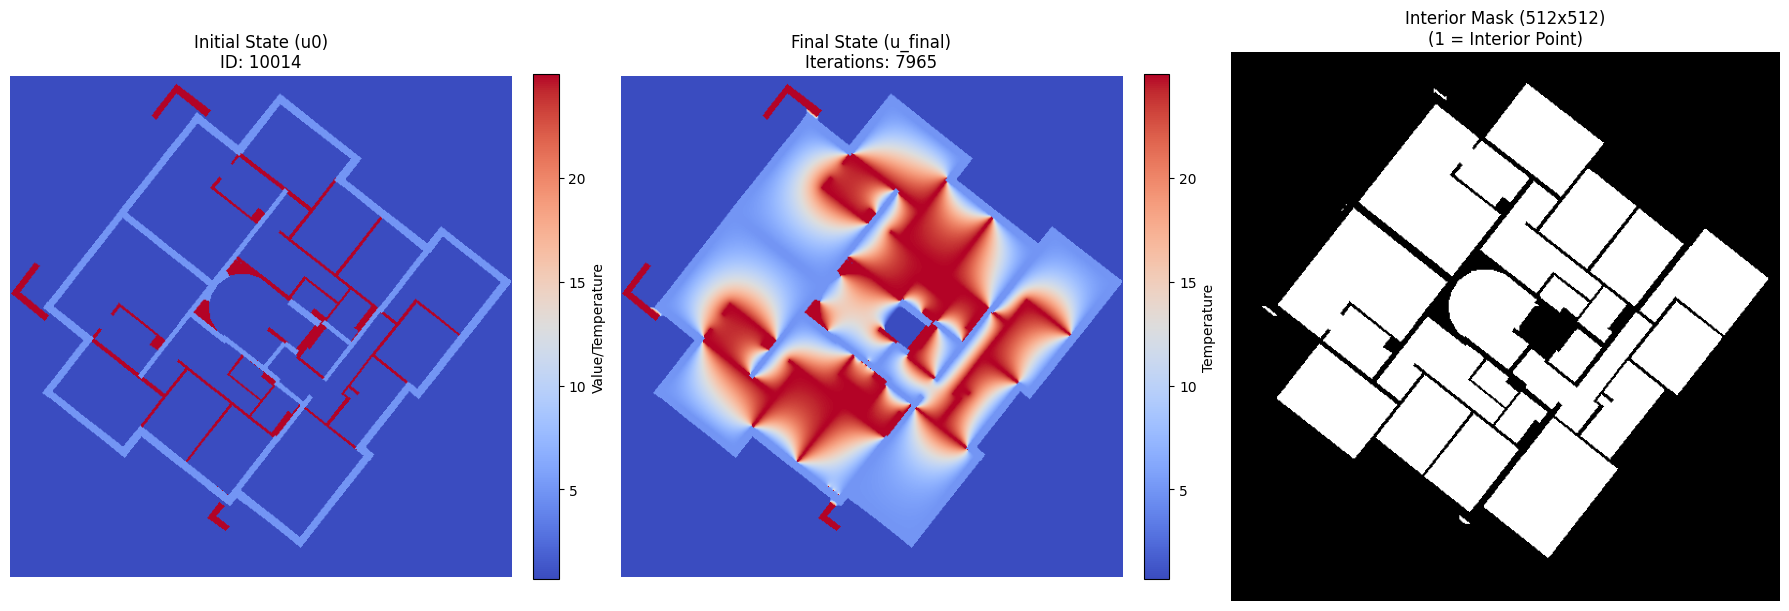


--- Visualization Complete ---


In [23]:
print(f"\n--- Visualizing Results for {min(NUM_TO_VISUALIZE, NUM_SUBSET)} Floorplans ---")

if not subset_u_final:
    print("No simulation results available to visualize.")
else:
    # Select which IDs to visualize (e.g., the first few processed)
    ids_to_visualize = valid_ids_processed[:min(NUM_TO_VISUALIZE, len(valid_ids_processed))]

    for bid in ids_to_visualize:
        print(f"\nVisualizing ID: {bid}")
        u0 = subset_u0[bid]
        u_final = subset_u_final[bid]
        # We need the 512x512 interior mask for plotting
        interior_mask = subset_interior_mask[bid]

        plot_simulation_results(bid, u0, u_final, interior_mask)

print("\n--- Visualization Complete ---")